In [7]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns

In [40]:
folds = 5
experiments = ["ratio"]
dfs = dict()
for e in experiments:
    paths = [Path(f"results/EXP_{e}_f{f}.csv") for f in range(folds)]
    paths = [p for p in paths if p.exists()] 
    dfs[e] = pd.concat([pd.read_csv(p) for p in paths])

In [62]:
df: pd.DataFrame = dfs["ratio"]
cols = [c for c in df.columns if ("target_test" in c) and ("nepochs" not in c)]
print(df.groupby("nframes_pre")["dataset"].count())
xd = df.groupby("nframes_pre")[cols].mean(numeric_only=True)
xd.set_index(pd.Series(name="ratio pretrain/train", data=[0,1,2,3], dtype=int), inplace=True)
xd

nframes_pre
0        5
6045     5
12090    5
18135    5
Name: dataset, dtype: int64


,target_test_acc,target_test_f1,target_test_auroc
ratio pretrain/train,,,
0,0.607218,0.607218,0.657215
1,0.662657,0.662657,0.712628
2,0.674486,0.674486,0.726777
3,0.656140,0.656140,0.702950


<AxesSubplot: xlabel='ratio pretrain/train'>

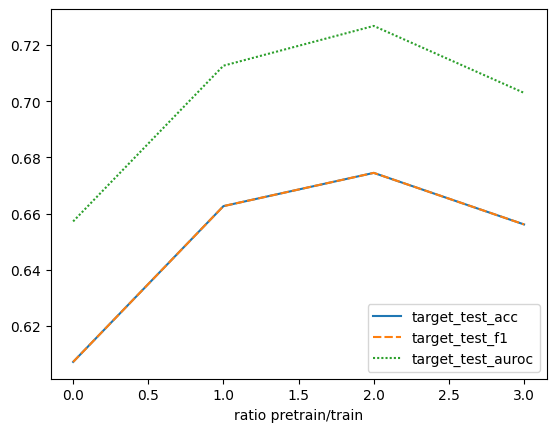

In [60]:
sns.lineplot(xd)

In [53]:
df = pd.read_csv("results/results.csv")
df["lab_shifts"] = df["lab_shifts"].str.slice(start=1,stop=-1).astype("category")
df

,dataset,fold_number,decoder,seed_sts,seed_label,batch_size,window_size,lab_shifts,nframes_tra,nframes_pre,...,aux_nepochs,pre_val_acc,pre_val_f1,pre_val_auroc,pre_test_acc,pre_test_f1,pre_test_auroc,pre_best_model,pre_train_csv,pre_nepochs
0,GunPoint,0,CNN,0,0,128,5,0,10000,40000,...,9,0.838825,0.838825,0.852924,0.646570,0.646570,0.714243,training/auto/0_0_2023-02-01_11-26/logs/pre/ch...,training/auto/0_0_2023-02-01_11-26/logs/pre/me...,122
1,GunPoint,0,CNN,0,0,128,5,0,10000,40000,...,6,0.841496,0.841496,0.857805,0.636455,0.636455,0.712427,training/auto/0_1_2023-02-01_11-37/logs/pre/ch...,training/auto/0_1_2023-02-01_11-37/logs/pre/me...,96
2,GunPoint,0,CNN,0,0,128,5,0.15,10000,40000,...,15,0.840012,0.840012,0.856416,0.637757,0.637757,0.714550,training/auto/0_2_2023-02-01_11-48/logs/pre/ch...,training/auto/0_2_2023-02-01_11-48/logs/pre/me...,100
3,GunPoint,0,CNN,0,0,128,5,0.15,10000,40000,...,7,0.831998,0.831998,0.852894,0.637957,0.637957,0.705994,training/auto/0_3_2023-02-01_11-59/logs/pre/ch...,training/auto/0_3_2023-02-01_11-59/logs/pre/me...,74


In [54]:
df.groupby("lab_shifts")[["def_test_f1", "pre_test_f1"]].mean()

,def_test_f1,pre_test_f1
lab_shifts,,
0,0.635103,0.641512
0.15,0.625538,0.637857


0.6320480704307556 0.6465698480606079


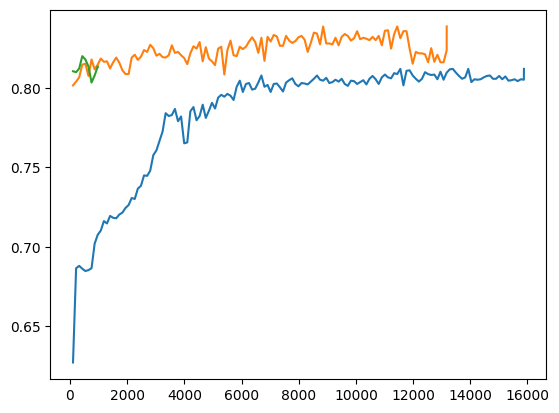

In [21]:
df_def = pd.read_csv("training/auto/0_0_2023-02-01_11-26/logs/def/metrics.csv")
df_aux = pd.read_csv("training/auto/0_0_2023-02-01_11-26/logs/aux/metrics.csv")
df_pre = pd.read_csv("training/auto/0_0_2023-02-01_11-26/logs/pre/metrics.csv")
df_def["val_f1"].dropna().plot()
df_pre["val_f1"].dropna().plot()
df_aux["val_f1"].dropna().plot()
print(df_def["test_f1"].max(), df_pre["test_f1"].max())

0.6381572484970093 0.636454701423645


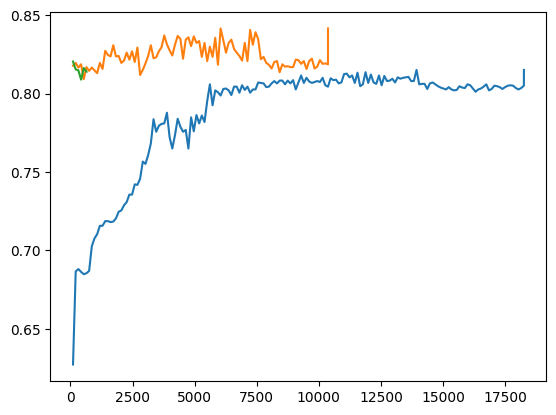

In [23]:
df_def = pd.read_csv("training/auto/0_1_2023-02-01_11-37/logs/def/metrics.csv")
df_aux = pd.read_csv("training/auto/0_1_2023-02-01_11-37/logs/aux/metrics.csv")
df_pre = pd.read_csv("training/auto/0_1_2023-02-01_11-37/logs/pre/metrics.csv")
df_def["val_f1"].dropna().plot()
df_pre["val_f1"].dropna().plot()
df_aux["val_f1"].dropna().plot()
print(df_def["test_f1"].max(), df_pre["test_f1"].max())